In [1]:
from bs4 import BeautifulSoup
import requests
import time
import csv
from tqdm import tqdm
from textblob import TextBlob
from transformers import pipeline
import spacy
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import re
import os
import matplotlib.colors as mcolors


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Génération d'un Dataset pour l'Analyse des Articles sur l'Agriculture Biologique

## Objectif
Créer un dataset avec des articles de **Le Monde** sur l'agriculture biologique (2000-2024). Les articles sont enrichis avec les informations suivantes :  
- **Titre**, **Résumé**, **URL**, **Date de publication**  
- **Average_Sentiment_Score** : Score moyen de sentiment (0 à 1) sur le résumé entier  

## Méthodologie

1. **Phase 1 - Analyse de la section principale "Agriculture"**  
   Dans un premier temps, nous avons collecté les articles présents sur la page principale de la section *Agriculture* de **Le Monde**. Nous avons extrait les titres, résumés, URLs et dates de publication des articles, en sélectionnant ceux contenant des mots-clés pertinents tels que *agriculture bio*.  

2. **Phase 2 - Collecte des archives historiques**  
   Pour obtenir les articles des années précédentes, nous avons réalisé un scraping des pages d'archives couvrant la période 2000-2024.  
   - Lors du scraping, les articles ont été sélectionnés sur la base des mots-clés suivants :  
     `["agriculture", "bio", "label", "alimentation", "agriculteur", "pesticide", "environnements", "durable", "écolo"]`.  
   - Une fois les articles collectés, nous avons filtré ceux contenant spécifiquement le terme *agriculture bio* dans leur titre ou résumé pour inclusion dans le dataset.  

3. **Analyse de sentiment**  
   Une analyse de sentiment a été réalisée sur le résumé entier de chaque article retenu. Un score de sentiment a été attribué à chaque article, allant de 0 (négatif) à 1 (positif).  

4. **Structure du Dataset**  
   Le dataset final contient les colonnes suivantes :  
   - **Title** : Le titre de l'article  
   - **Summary** : Le résumé de l'article  
   - **URL** : Le lien vers l'article  
   - **Date** : La date de publication  
   - **Average_Sentiment_Score** : Une valeur entre 0 et 1 représentant la tonalité générale de l'article  


In [ ]:
# Définir les en-têtes HTTP pour éviter d'être bloqué
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}

## Fonctions qui vont nous être utile pour les deux sections

In [ ]:
# Fonction pour scraper une page et récupérer tous les articles
def scrape_all_page(url):
    all_articles = []  # Liste de tous les articles
    seen_articles = set()  # Ensemble pour garder trace des articles déjà ajoutés

    try:
        # Envoyer une requête HTTP pour obtenir la page
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Trouver tous les articles dans les balises <div class="thread">
            articles = soup.find_all("div", class_="thread")
            
            for article in articles:
                # Extraire le titre
                title_element = article.find("h3", class_="teaser__title")
                title_text = title_element.get_text(strip=True) if title_element else "Titre non disponible"
                
                # Extraire l'URL de l'article
                link_element = article.find("a", class_="teaser__link")
                article_url = link_element["href"] if link_element else None
                if article_url and not article_url.startswith("http"):
                    article_url = f"https://www.lemonde.fr{article_url}"  # Construire l'URL complète si nécessaire
                
                # Extraire la description
                description_element = article.find("p", class_="teaser__desc")
                description_text = description_element.get_text(strip=True) if description_element else "Description non disponible"
                
                # Ajouter l'article à la liste si non déjà vu
                if article_url and article_url not in seen_articles:
                    all_articles.append([title_text, description_text, article_url])
                    seen_articles.add(article_url)

            return all_articles

        else:
            print(f"Erreur HTTP {response.status_code} lors de l'accès à {url}")
            return []

    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return []

In [ ]:
def extract_date_from_url(url):
    """
    Extrait la date au format YYYY/MM/DD d'une URL de l'article.
    """
    # Expression régulière pour extraire la date au format YYYY/MM/DD
    date_pattern = r'(\d{4})/(\d{2})/(\d{2})'
    match = re.search(date_pattern, url)
    
    if match:
        # Retourner la date au format YYYY-MM-DD
        return f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
    else:
        return None  # Si aucune date n'est trouvée

In [ ]:
# Fonction pour extraire les informations d'un article
def fetch_article_details(article_data, headers):
    title, summary, url = article_data
    try:
        # Faire la requête HTTP
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extraire le titre
            title_tag = soup.find('h1', class_='article__title')
            title = title_tag.get_text(strip=True) if title_tag else "Titre non trouvé"

            # Extraire la description (résumé) depuis la balise <p class="article__desc">
            summary_tag = soup.find('p', class_='article__desc')
            summary = summary_tag.get_text(strip=True) if summary_tag else "Résumé non trouvé"

            # Extraire la date de publication depuis la section 'meta__date-reading'
            date = extract_date_from_url(url)

            # Extraire uniquement le premier paragraphe à partir de la classe 'article__paragraph'
            first_paragraph_tag = soup.find('p', class_='article__paragraph')
            first_paragraph = first_paragraph_tag.get_text(strip=True) if first_paragraph_tag else "Premier paragraphe non trouvé"

            return {
                "Title": title,
                "Summary": summary,
                "Date": date,
                "First_Paragraph": first_paragraph
            }
        else:
            print(f"Erreur HTTP {response.status_code} pour {url}")
            return None
    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return None


In [ ]:
# Fonction pour filtrer les articles contenant le mot "bio" et inclure une liste des textes où il a été trouvé
def filter_bio_articles(detailed_articles):
    bio_articles = []
    
    # Parcourir tous les articles de detailed_articles
    for article in detailed_articles:
        # Initialiser une liste pour stocker les textes où "bio" est trouvé
        found_in_texts = []
        
        # Vérifier si le mot "bio" est présent dans le titre
        if "bio" in article['Title'].lower():
            found_in_texts.append(article['Title'])
        
        # Vérifier si le mot "bio" est présent dans la description (résumé)
        if "bio" in article['Summary'].lower():
            found_in_texts.append(article['Summary'])
        
        # Vérifier si le mot "bio" est présent dans le premier paragraphe
        if "bio" in article['First_Paragraph'].lower():
            found_in_texts.append(article['First_Paragraph'])
        
        # Si le mot "bio" est trouvé dans l'un des champs, ajouter l'article à la liste bio_articles
        if found_in_texts:
            article["Found_in"] = found_in_texts  # Ajouter les textes où "bio" a été trouvé sous forme de liste
            bio_articles.append(article)
    
    return bio_articles

In [37]:
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_bio_with_model(text):
    """
    Utilise un modèle open-source pour analyser le sentiment d'un texte concernant le bio.
    Si le modèle échoue ou n'est pas disponible, retourne un score neutre de 0,5.
    
    Le score sera entre 0 (négatif) et 1 (positif).
    """
    if sentiment_analyzer is None:
        # Si le modèle n'est pas chargé, retourner un score neutre
        print("Le modèle de sentiment n'est pas disponible. Retourne un score neutre (0,5).")
        return 0.5

    try:
        # Utiliser le modèle de sentiment pour prédire le sentiment
        result = sentiment_analyzer(text)
        sentiment = result[0]  # Le modèle retourne une liste avec un dict contenant labels et scores

        # Convertir le label en score
        if sentiment['label'] == 'POSITIVE':
            return sentiment['score']
        else:
            return 1 - sentiment['score']  # Retourner un score entre 0 et 1 pour un sentiment négatif
    except Exception as e:
        # En cas d'erreur, retourner un score neutre
        print(f"Erreur lors de l'analyse de sentiment : {e}")
        return 0.5


Device set to use cpu


In [15]:
# Fonction pour appliquer l'analyse de sentiment à chaque élément dans la liste de dictionnaires
def add_sentiment_score_to_list_of_dicts(data):
    """
    Applique l'analyse de sentiment sur chaque phrase de la clé 'Found_in' dans une liste de dictionnaires
    et ajoute la moyenne des scores de sentiment à chaque dictionnaire.
    """
    for entry in data:
        # Extraire les phrases de la clé 'Found_in'
        sentences = entry['Found_in']
        
        # Appliquer l'analyse de sentiment à chaque phrase
        sentiment_scores = [analyze_sentiment_bio_with_model(sentence) for sentence in sentences]
        
        # Calculer la moyenne des scores
        average_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        # Ajouter la moyenne au dictionnaire
        entry['Average_Sentiment_Score'] = average_score
    
    return data

## Phase 1 - Analyse de la section principale "Agriculture"

In [ ]:
# utilisation pour la page de la section agriculture du journal LeMonde
url_1 = "https://www.lemonde.fr/agriculture/"
url_2 = "https://www.lemonde.fr/agriculture/2"
articles = scrape_all_page(url_1)
articles += scrape_all_page(url_2)

In [5]:
# Liste pour stocker les résultats détaillés de chaque article
detailed_articles = []

# Boucle pour appliquer la fonction à chaque article
for article_data in articles:
    article_details = fetch_article_details(article_data, headers)
    
    # Si les détails de l'article ont été extraits avec succès, ajoutez-les à la liste
    if article_details:
        detailed_articles.append(article_details)


In [ ]:
# Appliquer la fonction pour filtrer les articles contenant le mot "bio"
bio_filtered_articles = filter_bio_articles(detailed_articles)

In [ ]:
# Appliquer la fonction pour ajouter la moyenne des scores de sentiment à chaque dictionnaire
data_with_scores = add_sentiment_score_to_list_of_dicts(bio_filtered_articles)

In [ ]:
def plot_sentiment_score_by_date(data):
    """
    Génère un graphique avec une barre pour chaque mois, colorée en fonction du score moyen de sentiment.
    Les mois sont affichés sous chaque barre.

    :param data: Liste de dictionnaires contenant les articles avec les scores de sentiment et les dates.
    """
    # Initialisation des dictionnaires pour compter les articles et calculer la somme des scores par mois
    articles_per_month = {}
    scores_per_month = {}

    for entry in data:
        date_str = entry['Date']
        score = entry['Average_Sentiment_Score']  # Score de sentiment
        
        try:
            # Essayer de convertir la date au format 'YYYY-MM-DD'
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            
            # Formater la date pour obtenir le mois et l'année (format 'YYYY-MM')
            month_year = date_obj.strftime('%Y-%m')
            
            # Incrémenter le compteur pour le mois et ajouter le score pour le calcul du score moyen
            if month_year not in articles_per_month:
                articles_per_month[month_year] = 0
                scores_per_month[month_year] = 0.0
            articles_per_month[month_year] += 1
            scores_per_month[month_year] += score
        except ValueError as e:
            print(f"Erreur de format de date pour '{entry['Title']}': {e}")
            continue

    # Calculer le score moyen par mois
    average_scores = {month: scores_per_month[month] / articles_per_month[month] for month in articles_per_month}

    # Créer une liste de tous les mois de l'année (en format YYYY-MM)
    all_months = pd.date_range(start=min(pd.to_datetime(list(articles_per_month.keys()))), 
                               end=max(pd.to_datetime(list(articles_per_month.keys()))), 
                               freq='MS').strftime('%Y-%m').tolist()

    # Liste des mois avec ou sans articles
    month_labels = []
    month_counts = []
    month_scores = []
    
    # Ajouter des mois manquants (ceux sans articles)
    for month in all_months:
        month_labels.append(month)
        month_counts.append(articles_per_month.get(month, 0))
        month_scores.append(average_scores.get(month, 0))

    # Créer un DataFrame avec les mois, le nombre d'articles et le score moyen
    df = pd.DataFrame({
        'Month': month_labels,
        'Article_Count': month_counts,
        'Average_Score': month_scores
    })

    # Créer une échelle de couleurs pour les scores (de rouge à vert)
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.colormaps['RdYlGn']  # Palette de couleurs allant de rouge (0) à vert (1)
    
    # Tracer les données
    fig, ax = plt.subplots(figsize=(12, 7))
    bar_colors = [cmap(norm(score)) for score in df['Average_Score']]  # Couleur des barres en fonction du score moyen
    bars = ax.bar(df['Month'], df['Article_Count'], color=bar_colors)

    # Ajouter des labels et un titre
    ax.set_xlabel('Mois de Publication', fontsize=12)
    ax.set_ylabel('Nombre d\'Articles', fontsize=12)
    ax.set_title('Nombre d\'Articles par Mois avec Scores Moyens', fontsize=14)

    # Rotation des labels de l'axe X pour une meilleure lisibilité
    plt.xticks(rotation=45, fontsize=10)

    # Définir les ticks de l'axe X (positionner les mois)
    tick_positions = range(len(df['Month']))
    ax.set_xticks(tick_positions)

    # Mettre l'année une seule fois pour chaque année
    ax.set_xticklabels([label if i == 0 or label[:4] != df['Month'][i-1][:4] else label[5:] for i, label in enumerate(df['Month'])])

    # Ajouter une grille
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajouter une légende de couleur (colorbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Nécessaire pour afficher la légende
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
    cbar.set_label('Score Moyen')

    # Ajustement des marges
    plt.tight_layout()

    # Afficher le graphique
    plt.show()


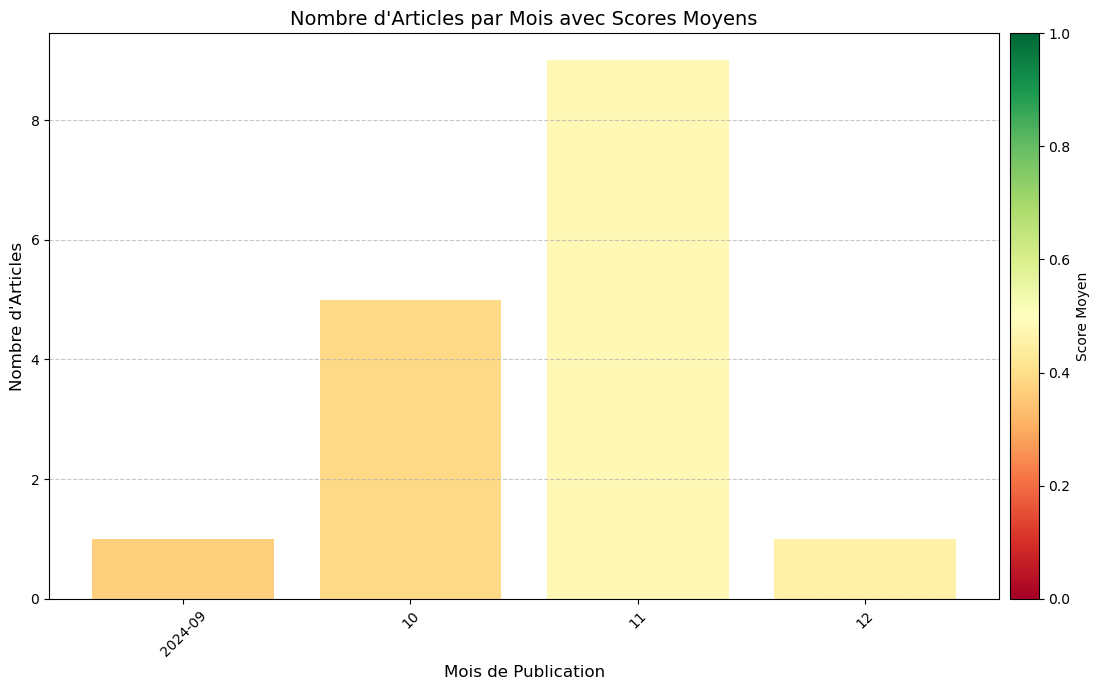

In [11]:
plot_sentiment_score_by_date(bio_filtered_articles)

## Phase 2 - Collecte des archives historiques

In [2]:
# Liste des mots-clés à rechercher dans les titres
keywords = ["agriculture", "bio", "label", "alimentation", "agriculteur", "pesticide", "environnements", "durable", "écolo"]

# Fonction pour vérifier si un titre contient un mot-clé
def contains_keyword(title, keywords):
    return any(keyword.lower() in title.lower() for keyword in keywords)

In [3]:
# Fonction pour scraper les articles d'une page
def scrape_page_archive(url):
    articles = []  # Liste des articles à retourner
    try:
        # Envoyer la requête HTTP
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            sections = soup.find_all('section', class_='teaser teaser--inline-picture')

            # Scraper chaque article
            for section in sections:
                title_element = section.find('h3', class_='teaser__title')
                link_element = section.find('a', class_='teaser__link')

                if title_element and link_element:
                    title = title_element.get_text(strip=True)
                    link = link_element.get('href')

                    # Vérifier si le titre contient un des mots-clés
                    if contains_keyword(title, keywords):
                        articles.append({
                            'title': title,
                            'link': link,
                            'date': url.split('/')[4]  # Extraire la date de l'URL
                        })
        else:
            print(f"Erreur HTTP {response.status_code} pour {url}")
    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")

    return articles

In [4]:
# Fonction pour obtenir le nombre total de pages depuis la pagination
def get_total_pages(url):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Trouver la section de pagination
            pagination_section = soup.find('section', class_='river__pagination')
            if pagination_section:
                # Trouver tous les liens de page
                page_links = pagination_section.find_all('a', class_='river__pagination--page')

                # Extraire les numéros de page et retourner le maximum
                page_numbers = [int(link.get_text()) for link in page_links if link.get_text().isdigit()]
                if page_numbers:
                    return max(page_numbers)  # Le nombre total de pages est le plus grand numéro
            else:
                print("Aucune section de pagination trouvée.")
    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
    
    return 1  # Si aucune pagination n'est trouvée, retourner 1 pour éviter la boucle infinie

In [5]:
# Fonction pour scraper toutes les pages à partir de la première
def scrape_all_pages(url_base):
    all_articles = []
    total_articles = 0  # Variable pour suivre le nombre d'articles traités
    
    # Obtenir le nombre total de pages à scraper
    total_pages = get_total_pages(url_base)
    print(f"Nombre total de pages : {total_pages}")

    # Scraper chaque page
    for page_num in range(1, total_pages + 1):
        url = f'{url_base}{page_num}/'  # URL de la page suivante
        print(f"Scraping {url}...")

        # Scraper les articles de cette page
        articles = scrape_page_archive(url)
        all_articles.extend(articles)

        # Mettre à jour le compteur d'articles
        total_articles += len(articles)

        # Afficher le nombre d'articles traités
        print(f"Articles traités jusqu'à présent : {total_articles}")

        # Pause de 10 secondes pour ne pas surcharger le serveur
        print("Attente de 10 secondes...")
        time.sleep(2)

    print(f"Scraping terminé. Nombre total d'articles traités : {total_articles}")
    return all_articles

In [6]:
# Fonction pour générer les URLs de chaque date en 2000
def generate_urls_for_year(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    current_date = start_date

    while current_date <= end_date:
        # Formater la date en JJ-MM-YYYY pour l'URL
        date_str = current_date.strftime("%d-%m-%Y")
        url_base = f"https://www.lemonde.fr/archives-du-monde/{date_str}/"
        yield url_base
        # Passer au jour suivant
        current_date += timedelta(days=1)

In [7]:
# Fonction principale pour scraper toutes les dates de l'année 2000
def scrape_articles_for_year(year):
    all_articles = []
    total_articles = 0  # Compteur d'articles traités

    # Générer les URLs pour toutes les dates de l'année
    for url_base in generate_urls_for_year(year):
        print(f"Scraping les articles pour {url_base}...")

        # Scraper les articles pour cette date
        articles = scrape_all_pages(url_base)
        all_articles.extend(articles)
        
        # Mettre à jour le compteur d'articles
        total_articles += len(articles)
        
        # Afficher le nombre d'articles traités
        print(f"Total d'articles traités jusqu'à {url_base} : {total_articles}")

    print(f"Scraping terminé. Nombre total d'articles traités pour l'année {year} : {total_articles}")
    return all_articles

Attention : Nous avons exécuté les deux cellules suivantes 24 fois, une fois pour chaque année, ce qui représente un temps total de traitement d’environ 24 heures (1 heure par année). Pour optimiser ce processus, nous avons enregistré les données au fur et à mesure dans un fichier CSV.

In [8]:
# Exemple d'utilisation : Scraper les articles pour l'année 2000
year = 2024
articles = scrape_articles_for_year(year)

Scraping les articles pour https://www.lemonde.fr/archives-du-monde/01-01-2024/...


Nombre total de pages : 2
Scraping https://www.lemonde.fr/archives-du-monde/01-01-2024/1/...
Articles traités jusqu'à présent : 1
Attente de 10 secondes...
Scraping https://www.lemonde.fr/archives-du-monde/01-01-2024/2/...
Articles traités jusqu'à présent : 1
Attente de 10 secondes...
Scraping terminé. Nombre total d'articles traités : 1
Total d'articles traités jusqu'à https://www.lemonde.fr/archives-du-monde/01-01-2024/ : 1
Scraping les articles pour https://www.lemonde.fr/archives-du-monde/02-01-2024/...
Nombre total de pages : 2
Scraping https://www.lemonde.fr/archives-du-monde/02-01-2024/1/...
Articles traités jusqu'à présent : 1
Attente de 10 secondes...
Scraping https://www.lemonde.fr/archives-du-monde/02-01-2024/2/...
Articles traités jusqu'à présent : 3
Attente de 10 secondes...
Scraping terminé. Nombre total d'articles traités : 3
Total d'articles traités jusqu'à https://www.lemonde.fr/archives-du-monde/02-01-2024/ : 4
Scraping les articles pour https://www.lemonde.fr/archive

In [9]:
# Nom du fichier CSV
csv_filename = "archive_le_monde.csv"

# Enregistrement dans un fichier CSV
def save_to_csv(data, filename):
    # Définir les en-têtes (correspondant aux clés du dictionnaire)
    headers = ['title', 'link', 'date']
    
    # Vérifier si le fichier existe déjà
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        
        # Écrire les en-têtes seulement si le fichier est créé (n'existe pas encore)
        if not file_exists:
            writer.writeheader()
        
        # Ajouter les données ligne par ligne
        for article in data:
            writer.writerow(article)
    
    print(f"Les articles ont été ajoutés au fichier '{filename}'.")



In [10]:

# Appeler la fonction pour enregistrer ou ajouter des données
save_to_csv(articles, csv_filename)

Les articles ont été ajoutés au fichier 'archive_le_monde.csv'.


In [2]:

# Charger le CSV dans un DataFrame
df = pd.read_csv('data_LeMonde.csv')

# Convertir le DataFrame en une liste de dictionnaires
article_list = df.to_dict(orient='records')

print(article_list[0])

{'title': "L'Amazonie brésilienne s'engage dans le développement durable", 'link': 'https://www.lemonde.fr/archives/article/2000/01/08/l-amazonie-bresilienne-s-engage-dans-le-developpement-durable_3585339_1819218.html', 'date': '08-01-2000'}


In [7]:
len(article_list)

7838

Il y a trop d'articles on décide de ne garder que les articles dont le titre mentionne explicitement le bio ou l'agriculture. 

In [8]:
# Mots-clés à rechercher
keywords = ["bio ", "agriculture", "biologique"]

# Filtrage des articles
filtered_articles = [
    article for article in article_list
    if any(keyword.lower() in article['title'].lower() for keyword in keywords)
]

In [9]:
len(filtered_articles)

1278

In [3]:
# Fonction pour extraire les paragraphes d'un article et les ajouter au dataset
def fetch_paragraphs_from_url(article_data, headers):
    title = article_data['title']
    url = article_data['link']
    date = article_data['date']
    try:
        # Vérification de l'URL et ajout du schéma si nécessaire
        if not url.startswith("http"):
            url = f"https://{url}"
        
        # Faire la requête HTTP
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extraire tous les paragraphes de l'article à partir de la classe 'article__paragraph'
            paragraphs = soup.find_all('p', class_='article__paragraph')
            paragraphs_text = " ".join([para.get_text(strip=True) for para in paragraphs])

            # Retourner un dictionnaire avec les paragraphes ajoutés
            return {
                "Title": title,
                "Link": url,
                "Date": date,
                "Paragraphs": paragraphs_text
            }
        else:
            print(f"Erreur HTTP {response.status_code} pour {url}")
            return {
                "Title": title,
                "Link": url,
                "Date": date,
                "Paragraphs": "Paragraphes non trouvés"
            }
    
    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return {
            "Title": title,
            "Link": url,
            "Date": date,
            "Paragraphs": "Erreur lors de la requête"
        }


In [10]:
# Liste pour stocker les résultats
article_list_with_summary = []

# Parcourir chaque article dans la liste article_list
for article_data in filtered_articles:
    # Appliquer la fonction fetch_paragraphs_from_url à chaque élément
    result = fetch_paragraphs_from_url(article_data, headers)
    
    # Ajouter le résultat à la nouvelle liste
    article_list_with_summary.append(result)
    
    # Attendre 2 secondes avant de passer au prochain article
    time.sleep(2)

Erreur de requête pour https://www.lemonde.fr/archives/article/2001/02/09/virage-vers-l-agriculture-biologique_146281_1819218.html: HTTPSConnectionPool(host='www.lemonde.fr', port=443): Read timed out. (read timeout=10)
Erreur HTTP 404 pour http://sosconso.blog.lemonde.fr/2018/11/27/le-pere-biologique-peut-il-reconnaitre-lenfant-dune-femme-mariee/


In [11]:
def filter_bio_articles_archive(detailed_articles):
    bio_articles = []
    
    # Parcourir tous les articles de detailed_articles
    for article in detailed_articles:
        # Initialiser une liste pour stocker les textes où "bio" est trouvé
        found_in_texts = []
        
        # Vérifier si le mot "bio" est présent dans le titre
        if "bio" in article['Title'].lower():
            found_in_texts.append(article['Title'])
        
        # Vérifier si le mot "bio" est présent dans les paragraphes
        if "bio" in article['Paragraphs'].lower():
            found_in_texts.append(article['Paragraphs'])
        
        # Si le mot "bio" est trouvé dans l'un des champs, ajouter l'article à la liste bio_articles
        if found_in_texts:
            article["Found_in"] = found_in_texts  # Ajouter les textes où "bio" a été trouvé sous forme de liste
            bio_articles.append(article)
    
    return bio_articles


In [13]:
article_bio = filter_bio_articles_archive(article_list_with_summary)

In [31]:
def filter_sentences_by_word(data, keyword):
    """
    Filtre les phrases contenant un mot-clé spécifique dans le champ 'Found_in' d'une liste de dictionnaires.
    Gère le cas où 'Found_in' contient des paragraphes (plusieurs phrases) et coupe les phrases dépassant 500 tokens.

    :param data: Liste de dictionnaires contenant un champ 'Found_in'.
    :param keyword: Le mot-clé à rechercher (insensible à la casse).
    :return: Une nouvelle liste de dictionnaires avec le champ 'Found_in' filtré et coupé si nécessaire.
    """
    for item in data:
        if 'Found_in' in item:
            filtered_sentences = []
            for paragraph in item['Found_in']:
                # Séparer le paragraphe en phrases
                sentences = re.split(r'(?<=[.!?])\s+', paragraph)
                # Filtrer les phrases contenant le mot-clé
                relevant_sentences = [sentence for sentence in sentences if keyword.lower() in sentence.lower()]
                
                # Vérifier la longueur des phrases et couper si elles dépassent 500 tokens
                for sentence in relevant_sentences:
                    tokens = sentence.split()  # Diviser la phrase en tokens
                    if len(tokens) > 500:
                        # Diviser la phrase en morceaux de 500 tokens maximum
                        for i in range(0, len(tokens), 500):
                            part = ' '.join(tokens[i:i+500])
                            filtered_sentences.append(part)
                    else:
                        filtered_sentences.append(sentence)
            
            # Remplacer 'Found_in' par les phrases filtrées
            item['Found_in'] = filtered_sentences
    return data


In [32]:
article_bio_filtered = filter_sentences_by_word(article_bio, "bio")

In [38]:
article_bio_sentiment = add_sentiment_score_to_list_of_dicts(article_bio_filtered)

Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


Erreur lors de l'analyse de sentiment : The size of tensor a (531) must match the size of tensor b (512) at non-singleton dimension 1


In [39]:
def save_to_csv_3(data, filename):
    # Ouvrir le fichier CSV en mode écriture
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        # Créer un writer CSV
        writer = csv.DictWriter(file, fieldnames=data[0].keys())
        
        # Écrire l'en-tête (les noms de colonnes)
        writer.writeheader()
        
        # Écrire les lignes de données
        writer.writerows(data)

In [41]:
save_to_csv_3(article_bio_sentiment, "data_Lemonde.csv")